In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable

import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

import utils

In [2]:
aluminium_inputs = joblib.load('../Vectors/single_f_aluminium_vectors')
aluminium_labels = joblib.load('../Vectors/single_f_aluminium_labels')
aluminium_dates = joblib.load('../Vectors/single_f_aluminium_dates')

In [3]:
al_train_data = torch.from_numpy(aluminium_inputs)
al_train_labels = torch.from_numpy(aluminium_labels)
al_train_data = torch.squeeze(al_train_data, dim = 1)

In [4]:
print(al_train_data.shape)
print(al_train_labels.shape)

torch.Size([840, 55])
torch.Size([840])


In [5]:
data_dim = al_train_data.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 100))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(100, 20))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(20, 2))

feature_extractor = LargeFeatureExtractor()

In [6]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(al_train_data, al_train_labels, likelihood).double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

  0%|          | 0/500 [00:00<?, ?it/s]

C:\anaconda\lib\site-packages\gpytorch\utils\linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


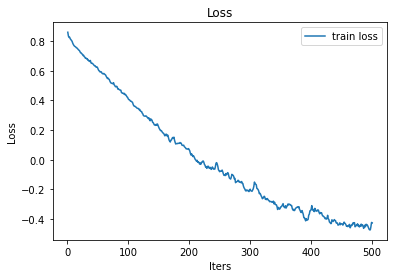

Wall time: 2min 27s


In [8]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 500

training_loss = []

def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(al_train_data)
        # Calc loss and backprop derivatives
        loss = -mll(output, al_train_labels)
        training_loss.append(loss.item())
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        
    index = [i+1 for i in range(len(training_loss))]
    #plt.plot(index, validation_loss ,label = "val loss")
    plt.plot(index, training_loss, label = "train loss")
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
        

%time train()

In [9]:
'''model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)'''

'model.eval()\nlikelihood.eval()\nwith torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():\n    preds = model(test_x)'